In [52]:
import numpy as np
import json
from tensorforce.agents import *
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym


In [53]:
agent_config = {
'actions_exploration': {
  'type': 'epsilon_anneal',
  'final_epsilon': 0.02,
  'initial_epsilon': 1.0,
  'timesteps': 10000},
 'discount': 1.0,
 'double_q_model': True,
 'huber_loss': 1.0,
 'memory': {
  'capacity': 50000, 'include_next_states': True, 'type': 'replay'},
  'optimizer': {'clipping_value': 0.01,
  'optimizer': {'learning_rate': 0.001, 'type': 'adam'},
  'type': 'clipped_step'},
 'target_sync_frequency': 500,
 'target_update_weight': 1.0,
 'type': 'dqn_agent',
 'update_mode': {
   'batch_size': 32,
   'first_update': 1000,
   'frequency': 1,
   'repeat_update': 1,
   'unit': 'timesteps'},
 'variable_noise': None}

network_spec = [
    {'activation': 'relu', 'size': 32, 'type': 'dense'},
     {'activation': 'relu', 'size': 32, 'type': 'dense'},
]

misc_config = {'episodes' : 500}


In [56]:
def test_agent(agent_config,network_spec,misc_config):
    # Network as list of layers
    # - Embedding layer:
    #   - For Gym environments utilizing a discrete observation space, an
    #     "embedding" layer should be inserted at the head of the network spec.
    #     Such environments are usually identified by either:
    #     - class ...Env(discrete.DiscreteEnv):
    #     - self.observation_space = spaces.Discrete(...)

    # Note that depending on the following layers used, the embedding layer *may* need a
    # flattening layer

    environment = OpenAIGym('LunarLander-v2', visualize=False)

    agent = Agent.from_spec(
    spec=agent_config,
    kwargs=dict(
        states=environment.states,
        actions=environment.actions,
        network=network_spec
    )
)

    # Create the runner
    runner = Runner(agent=agent, environment=environment)


    # Callback function printing episode statistics
    def episode_finished(r):
        if r.episode%100 == 0:
            print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep,
                                                                                     reward=r.episode_rewards[-1]))
        return True


    # Start learning
    runner.run(episodes=misc_config['episodes'], max_episode_timesteps=600, episode_finished=episode_finished)
    runner.close()

    # Print statistics
    print("Learning finished. Total episodes: {ep}. Average reward of last 100 episodes: {ar}.".format(
        ep=runner.episode,
        ar=np.mean(runner.episode_rewards[-100:]))
    )
    
    return runner.episode_rewards


In [57]:
learning_rates = [1e-3]
reps = 5

rewards = np.zeros((len(learning_rates),reps,misc_config['episodes']))
for i,learning_rate in enumerate(learning_rates):
    for j in range(reps):
        rewards[i,j,:] = test_agent(agent_config,network_spec,misc_config)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Finished episode 100 after 51 timesteps (reward: -342.23785467290884)
Finished episode 200 after 80 timesteps (reward: -570.8966958577026)
Finished episode 300 after 89 timesteps (reward: -380.2576845455283)
Finished episode 400 after 399 timesteps (reward: -238.6377509379052)
Finished episode 500 after 601 timesteps (reward: -119.75905293111371)
Learning finished. Total episodes: 500. Average reward of last 100 episodes: -134.06009376680709.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Finished episode 100 after 61 timesteps (reward: -596.7966850776903)
Finished episode 200 after 79 timesteps (rewar

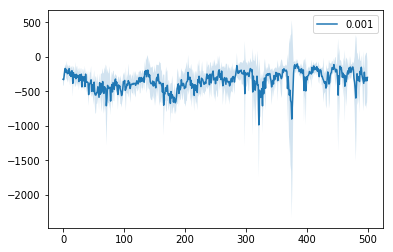

In [58]:
from matplotlib import pyplot as plt

x = range(misc_config['episodes'])
ys = np.mean(rewards,axis=1)

errors = np.std(rewards,axis=1)

for y,error,lr in zip(ys,errors,learning_rates):
    plt.plot(x, y, '-',label=lr)
    plt.fill_between(x, y-error, y+error,alpha=0.2)
plt.legend()
plt.show()
plt.close()